In [1]:
import glob
import pandas as pd
import numpy as np
import os, sys
import collections
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier 

In [3]:
from numba.typed import List
from numba import jit, njit, vectorize

In [4]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [5]:
sample_rate = 50  # number of observation per second based on dataset documentation(150 samples in 3 second)

sliding_size = int((1/3) * sample_rate)  # number of skipped datapoints to start next window
print(sliding_size)

16


# Feature sets

In [6]:
@njit()
def mean_crossing_rate(col):
    # col = np.array(values)
    normalized = col - col.mean()  # to make elements of array possitive or negetive
    return ((normalized[:-1] * col[1:]) < 0).sum()  # Zero-Crossing_rate

@njit()
def iqr(window):  # inter-quartile range
    Q1 = np.median(window[:len(window)//2])  # First quartile (Q1) 
    Q3 = np.median(window[len(window)//2:])  # Third quartile (Q3) 
    IQR = Q3 - Q1 # Interquartile range (IQR) 
    return(IQR) 
@njit()
def calc_sma_for_window(data):
    return np.sum(data) / len(data)  
@njit()
def get_min(x):
    m = np.min(x)
    return m
@njit()
def get_max(x):
    m = np.max(x)
    return m
@njit()
def get_mean(x):
    m = np.mean(x)
    return m
@njit()
def get_var(x):
    m = np.var(x)
    return m
@njit()
def get_mean(x):
    m = np.mean(x)
    return m
@njit()
def get_sum(x):
    m = x.sum()
    return m 
@njit()
def get_median(x):
    m = np.median(x)
    return m 
@njit()
def get_std(x):
    m = np.median(x)
    return m 
@njit()
def get_rng(x):
    n = np.max(x)
    m = np.min(x)
    z = n-m
    return z 

def get_rms(x, axis=None):
    return np.sqrt(np.mean(x ** 2, axis=axis))

def calc_sma_for_window(data):
    return np.sum(data) / len(data)


def calc_sma_adv_for_window(data):
    return np.sum(data - np.mean(data) / len(data))


def calc_absolutes_for_list(list):
    return ([abs(i) for i in list])

def get_sma(data): 
    sma_sim = calc_sma_for_window(data)
    sma_adv = calc_sma_adv_for_window(data)

    sma_sim_abs = calc_sma_for_window(calc_absolutes_for_list(data))
    sma_adv_abs = calc_sma_adv_for_window(calc_absolutes_for_list(data))

    return sma_sim, sma_adv, sma_sim_abs, sma_adv_abs

def get_entropy(Y):
    """
    Also known as Shanon Entropy
    Reference: https://en.wikipedia.org/wiki/Entropy_(information_theory)
    """
    unique, count = np.unique(Y, return_counts=True, axis=0)
    prob = count/len(Y)
    en = np.sum((-1)*prob*np.log2(prob))
    return en

In [7]:
def Energy(frame):
    return sum( [ abs(x)**2 for x in frame ] ) / len(frame)

# Feature extraction and Vector_Normalization on signal

In [8]:
def Features(window):# mean, std,max,min and zero-crossing-rate
    wind = window.iloc[:, :-1]
    win = np.array(wind)
    
    data_normalized = preprocessing.normalize(win, norm  = 'l1') # normalization on signal
    win = data_normalized
    features = []
    
    features.append(get_mean(win))
    features.append(get_median(win))
    features.append(get_std(win))
    features.append(get_min(win))
    features.append(get_max(win))
    features.append(get_sum(win))
    features.append(get_entropy(win))
    mean_crossing = [mean_crossing_rate(win[:, i]) for i in range(win.shape[1])]
    features.append(np.array(mean_crossing))
    IQR = iqr(win)
    features.append(np.array(IQR))
    energy_measure = Energy(win)
    features.append(np.array(energy_measure))
 

    
    features = np.hstack(features).tolist()
    
    label = window.iloc[:, -1].mode()[0]  ## select the most frequent label as the label of the window
    features.append(label)
    return features

In [9]:
def windowing_dataset(dataset, win_size, feature_extraction_function, subject_id, overlap=False):
    windowed_dataset = []
    win_count = 0
    if overlap:
        step_size = sliding_size  # for Overlapping technique
    else:
        step_size = win_size  # for Non-overlapping technique

    for index in range(0, dataset.shape[0], step_size):
        start = index
        end = start + win_size
        # to assure all of windows are equal in size
        if (end <= dataset.shape[0]):
            window = dataset.iloc[start:end, :].reset_index(drop=True)
            win_count = win_count + 1
            features = feature_extraction_function(window)

            windowed_dataset.append(features)

    final = pd.DataFrame(windowed_dataset)
    final.insert(0, 'group', subject_id)  # to use in Subject CV
    return final

In [10]:
def Preprocessing(dataset_path, overlapping):
    feature_function = Features
    win_size = 3

    print("Start for win size {}".format(win_size))
    datapoints_per_window = int(win_size * sample_rate)

    print(feature_function.__name__)

    ACC = []
    GYR = []
    MAG = []
    QUAD = []

    for subject in range(1,18):
        file_path = dataset_path + '\subject{0}_ideal.csv'.format(subject)
        acc_cols = []
        gyr_cols = []
        mag_cols = []
        quad_cols = []
        
#########################################################################################################################
        for i in range(2, 117, 13):# indices of accelarations
            indices = list(range(i, i + 3))
            acc_cols.extend(indices)

        acc_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=acc_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        ACC.append(transformed_db)
#########################################################################################################################
        for i in range(5, 117, 13):# indices of gyr
            indices = list(range(i, i + 3))
            gyr_cols.extend(indices)

        gyr_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=gyr_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        GYR.append(transformed_db)
#########################################################################################################################        
        for i in range(8, 117, 13):# indices of mag
            indices = list(range(i, i + 3))
            mag_cols.extend(indices)

        mag_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=mag_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        MAG.append(transformed_db)
#########################################################################################################################
        for i in range(11, 117, 13):# indices of quad
            indices = list(range(i, i + 4))
            quad_cols.extend(indices)

        quad_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=quad_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        QUAD.append(transformed_db)
#########################################################################################################################
    #final_dataset = pd.DataFrame()
    ACC_dataset = pd.DataFrame()
    GYR_dataset = pd.DataFrame()
    MAG_dataset = pd.DataFrame()
    QUAD_dataset= pd.DataFrame()
    ACC_dataset = ACC_dataset.append(ACC, ignore_index=True)
    GYR_dataset = GYR_dataset.append(GYR, ignore_index=True)
    MAG_dataset = MAG_dataset.append(MAG, ignore_index=True)
    QUAD_dataset = QUAD_dataset.append(QUAD, ignore_index=True)
    return ACC_dataset,GYR_dataset,MAG_dataset,QUAD_dataset
   

In [11]:
def subject_cross_validation(X, Y, groups, classifier):
    f1 = []
    logo = LeaveOneGroupOut()
    i = 0
    for train_index, test_index in logo.split(X, Y, groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        i += 1
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)
        f = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
        
        print('Model-',i ,' -',' f1 score: ', f)
       
        f1.append(f)
    return np.mean(f1)

In [12]:
def classifier(dataset, model):
    results = dict()
    win_size = float(3)
    print('window_size = ', win_size,' sec')

    dataset = dataset
    groups = dataset['group']
    X = dataset.iloc[:, 1:-1]
    X = np.array(X)
    
    Y = dataset.iloc[:, -1]
    Y = np.array(Y)

    for model_name, mod in model.items():
        f1 = 0

        f1 = subject_cross_validation(X, Y, groups, mod)

        if win_size in results:
            results[win_size].append(f1)
        else:
            results[win_size] = [f1]


        results = collections.OrderedDict(sorted(results.items()))

        final = []
        col = list(model.keys())
        col.insert(0, "window-size")
        final.append(col)
        for k, v in results.items():
            tmp = []
            tmp.append([k])
            tmp.append(v)
            flattened = [val for sublist in tmp for val in sublist]
            final.append(flattened)

    accuracy = final[1][1]
    
    return accuracy

In [13]:
mod = {'RF': RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)}

In [14]:
dataset_csv_path = r"D:\projec\proj\data"

overlapping = 1  # input 0 for non overlapping, 1 for overlapping

ACC, GYR,MAG,QUAD = Preprocessing(dataset_path=dataset_csv_path, overlapping=bool(int(overlapping)))

Start for win size 3
Features


In [15]:
ACC.head(10)

,group,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,61,62
0,1,-0.013594,-0.010226,-0.010226,-0.109026,0.090630,-55.053794,7.228819,51.0,77.0,...,0.005989,0.000154,0.000235,0.005603,0.000293,0.000421,0.006379,0.000126,0.000611,1
1,1,-0.013601,-0.010978,-0.010978,-0.109026,0.090630,-55.082442,7.228819,55.0,80.0,...,0.005886,0.000166,0.000253,0.005445,0.000285,0.000371,0.006478,0.000126,0.000550,1
2,1,-0.013649,-0.011704,-0.011704,-0.104240,0.090630,-55.279896,7.228819,56.0,76.0,...,0.005788,0.000183,0.000288,0.005475,0.000319,0.000420,0.006181,0.000132,0.000464,1
3,1,-0.014227,-0.011786,-0.011786,-0.104240,0.081952,-57.621280,7.228819,27.0,83.0,...,0.005849,0.000188,0.000256,0.005560,0.000340,0.000493,0.006198,0.000139,0.000363,1
4,1,-0.014725,-0.011360,-0.011360,-0.112615,0.100898,-59.635298,7.228819,22.0,97.0,...,0.005760,0.000167,0.000217,0.005515,0.000310,0.000459,0.006380,0.000132,0.000450,1
5,1,-0.015425,-0.011146,-0.011146,-0.118516,0.100898,-62.470994,7.228819,37.0,90.0,...,0.006008,0.000179,0.000220,0.005645,0.000300,0.000514,0.006381,0.000130,0.000643,1
6,1,-0.016505,-0.011714,-0.011714,-0.118516,0.100898,-66.844079,7.228819,42.0,78.0,...,0.006031,0.000199,0.000197,0.005712,0.000301,0.000486,0.006439,0.000137,0.000626,1
7,1,-0.017679,-0.012273,-0.012273,-0.118516,0.136410,-71.600716,7.228819,45.0,60.0,...,0.006044,0.000225,0.000330,0.005572,0.000294,0.000478,0.006537,0.000138,0.000577,1
8,1,-0.018890,-0.012241,-0.012241,-0.119470,0.136410,-76.506234,7.228819,51.0,58.0,...,0.006009,0.000264,0.000330,0.005890,0.000324,0.000562,0.006232,0.000149,0.000517,1
9,1,-0.020518,-0.012563,-0.012563,-0.139116,0.136410,-83.097093,7.228819,54.0,61.0,...,0.006145,0.000242,0.000326,0.005786,0.000290,0.000605,0.006805,0.000148,0.000735,1


In [16]:
GYR.head(10)

,group,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,61,62
0,1,0.000392,-0.000373,-0.000373,-0.410988,0.250327,1.588564,7.228819,25.0,9.0,...,0.003673,0.007334,0.001250,0.006214,0.008431,0.000723,0.005886,0.035691,0.001104,1
1,1,-0.000061,-0.001124,-0.001124,-0.410988,0.252434,-0.247592,7.228819,27.0,11.0,...,0.004308,0.008363,0.001174,0.004856,0.006029,0.000688,0.004450,0.032169,0.001093,1
2,1,0.000934,-0.000927,-0.000927,-0.360828,0.252434,3.781437,7.228819,22.0,10.0,...,0.004499,0.007648,0.001250,0.004918,0.006218,0.000613,0.002956,0.021292,0.000768,1
3,1,0.000522,-0.000559,-0.000559,-0.360828,0.252434,2.112438,7.228819,52.0,9.0,...,0.004441,0.007675,0.001361,0.005047,0.007025,0.000559,0.003595,0.020692,0.000651,1
4,1,0.000534,-0.000014,-0.000014,-0.360828,0.252434,2.161437,7.228819,47.0,9.0,...,0.003391,0.004840,0.001115,0.005094,0.007097,0.000478,0.004032,0.023591,0.000658,1
5,1,0.001365,0.001198,0.001198,-0.360828,0.252434,5.528329,7.228819,37.0,11.0,...,0.003406,0.004985,0.001159,0.004740,0.006853,0.000503,0.004221,0.024170,0.000737,1
6,1,0.000467,0.000240,0.000240,-0.360828,0.347139,1.891729,7.228819,44.0,11.0,...,0.003510,0.005590,0.000937,0.004233,0.006582,0.000509,0.004098,0.022073,0.000738,1
7,1,0.000009,-0.000121,-0.000121,-0.360828,0.347139,0.037444,7.228819,29.0,9.0,...,0.003436,0.005260,0.000777,0.002888,0.003425,0.000440,0.002900,0.020071,0.000681,1
8,1,0.000639,0.000337,0.000337,-0.293264,0.347139,2.588346,7.228819,18.0,10.0,...,0.003157,0.004666,0.000798,0.002326,0.004101,0.000432,0.002566,0.009648,0.000399,1
9,1,0.000297,0.000942,0.000942,-0.319690,0.347139,1.203491,7.228819,25.0,9.0,...,0.003244,0.004919,0.000701,0.002423,0.004097,0.000228,0.002826,0.014670,0.000345,1


In [17]:
MAG.head(10)

,group,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,61,62
0,1,0.015225,0.006583,0.006583,-0.062378,0.108242,61.661652,7.228819,79.0,86.0,...,0.005518,0.000057,0.000246,0.009626,0.000051,0.000592,0.006311,0.001008,0.001262,1
1,1,0.015216,0.007129,0.007129,-0.062378,0.108242,61.624595,7.228819,76.0,78.0,...,0.005503,0.000058,0.000278,0.009552,0.000053,0.000612,0.006360,0.001065,0.000986,1
2,1,0.015083,0.007215,0.007215,-0.060690,0.108242,61.085435,7.228819,71.0,79.0,...,0.005430,0.000052,0.000328,0.009325,0.000054,0.000829,0.006622,0.000948,0.000910,1
3,1,0.015293,0.007020,0.007020,-0.070671,0.108242,61.937313,7.228819,29.0,81.0,...,0.005487,0.000047,0.000310,0.009438,0.000060,0.000919,0.006970,0.000791,0.001035,1
4,1,0.015324,0.006369,0.006369,-0.104718,0.108242,62.063202,7.228819,15.0,131.0,...,0.005601,0.000059,0.000299,0.009558,0.000060,0.000883,0.007152,0.000719,0.001051,1
5,1,0.016012,0.006556,0.006556,-0.104718,0.123196,64.847816,7.228819,122.0,119.0,...,0.005526,0.000064,0.000262,0.009366,0.000051,0.000788,0.006790,0.000725,0.001136,1
6,1,0.017172,0.007527,0.007527,-0.104718,0.137939,69.546454,7.228819,109.0,105.0,...,0.005395,0.000061,0.000248,0.009359,0.000046,0.000625,0.006476,0.000726,0.001153,1
7,1,0.017401,0.007831,0.007831,-0.104718,0.137939,70.473121,7.228819,94.0,36.0,...,0.005206,0.000059,0.000278,0.008980,0.000042,0.000645,0.006445,0.000736,0.000869,1
8,1,0.018361,0.009457,0.009457,-0.104718,0.149417,74.363570,7.228819,80.0,46.0,...,0.004895,0.000047,0.000300,0.008445,0.000040,0.000729,0.006195,0.000658,0.000969,1
9,1,0.018911,0.008824,0.008824,-0.104718,0.155050,76.589754,7.228819,65.0,49.0,...,0.004680,0.000046,0.000258,0.008084,0.000052,0.000725,0.006179,0.000536,0.000867,1


In [18]:
QUAD.head(10)

,group,0,1,2,3,4,5,6,7,8,...,71,72,73,74,75,76,77,78,79,80
0,1,0.011482,0.019554,0.019554,-0.053215,0.059727,62.004603,7.228819,59.0,78.0,...,0.001267,0.000979,0.001508,0.000818,0.000785,0.000247,0.001750,0.000425,0.001669,1
1,1,0.011358,0.019499,0.019499,-0.053215,0.059727,61.335594,7.228819,64.0,82.0,...,0.001262,0.001007,0.001504,0.000840,0.000739,0.000241,0.001661,0.000377,0.001811,1
2,1,0.011234,0.019349,0.019349,-0.053215,0.059727,60.663898,7.228819,61.0,86.0,...,0.001311,0.000945,0.001610,0.000864,0.000677,0.000205,0.001736,0.000386,0.001768,1
3,1,0.011285,0.019382,0.019382,-0.053215,0.059713,60.941523,7.228819,43.0,102.0,...,0.001384,0.000877,0.001675,0.000846,0.000677,0.000186,0.001880,0.000439,0.001571,1
4,1,0.011238,0.019505,0.019505,-0.053215,0.059713,60.685443,7.228819,32.0,101.0,...,0.001399,0.000867,0.001640,0.000826,0.000713,0.000205,0.001901,0.000458,0.001482,1
5,1,0.011078,0.019563,0.019563,-0.053215,0.059305,59.821561,7.228819,45.0,100.0,...,0.001316,0.000893,0.001567,0.000829,0.000729,0.000216,0.001842,0.000440,0.001520,1
6,1,0.010820,0.019491,0.019491,-0.053215,0.059305,58.425322,7.228819,56.0,96.0,...,0.001263,0.000928,0.001488,0.000833,0.000736,0.000220,0.001779,0.000421,0.001564,1
7,1,0.010391,0.019271,0.019271,-0.055520,0.059305,56.111793,7.228819,69.0,85.0,...,0.001241,0.000927,0.001482,0.000854,0.000693,0.000220,0.001697,0.000387,0.001652,1
8,1,0.010134,0.018954,0.018954,-0.055520,0.059305,54.724655,7.228819,82.0,88.0,...,0.001275,0.000858,0.001549,0.000862,0.000659,0.000190,0.001768,0.000407,0.001563,1
9,1,0.010032,0.019189,0.019189,-0.055520,0.059027,54.171522,7.228819,95.0,93.0,...,0.001292,0.000834,0.001529,0.000851,0.000670,0.000198,0.001812,0.000430,0.001445,1


In [19]:
print('ACC_accuracy = ', )
ACC_accuracy = classifier(dataset=ACC, model=mod)
ACC_accuracy 

ACC_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.8318181818181818
Model- 2  -  f1 score:  0.976031018681706
Model- 3  -  f1 score:  0.9328
Model- 4  -  f1 score:  0.9573198715006884
Model- 5  -  f1 score:  0.9220689655172414
Model- 6  -  f1 score:  0.9611111111111111
Model- 7  -  f1 score:  0.8005540166204986
Model- 8  -  f1 score:  0.955837173579109
Model- 9  -  f1 score:  0.9494017094017094
Model- 10  -  f1 score:  0.9610788665073404
Model- 11  -  f1 score:  0.975625
Model- 12  -  f1 score:  0.9287060301507539
Model- 13  -  f1 score:  0.9189952018063787
Model- 14  -  f1 score:  0.9155227032734953
Model- 15  -  f1 score:  0.9411000433087917
Model- 16  -  f1 score:  0.7764791818845873
Model- 17  -  f1 score:  0.8855077976416889


0.9170562866354872

In [20]:
print('GYR_accuracy = ', )
GYR_accuracy = classifier(dataset=GYR, model=mod)
GYR_accuracy

GYR_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.8786713286713287
Model- 2  -  f1 score:  0.9249206908706379
Model- 3  -  f1 score:  0.9256
Model- 4  -  f1 score:  0.9417163836622305
Model- 5  -  f1 score:  0.8648275862068966
Model- 6  -  f1 score:  0.8877777777777778
Model- 7  -  f1 score:  0.9944598337950139
Model- 8  -  f1 score:  0.9120583717357912
Model- 9  -  f1 score:  0.9131623931623931
Model- 10  -  f1 score:  0.9115739160122909
Model- 11  -  f1 score:  0.909375
Model- 12  -  f1 score:  0.8951005025125628
Model- 13  -  f1 score:  0.9071408410951172
Model- 14  -  f1 score:  0.8803238296374516
Model- 15  -  f1 score:  0.9281074058033781
Model- 16  -  f1 score:  0.87509130752374
Model- 17  -  f1 score:  0.8337771015595283


0.9049226041191847

In [21]:
print('MAG_accuracy = ', )
MAG_accuracy = classifier(dataset=MAG, model=mod)
MAG_accuracy

MAG_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.7220279720279719
Model- 2  -  f1 score:  0.7881565033486077
Model- 3  -  f1 score:  0.8028
Model- 4  -  f1 score:  0.9137218907755851
Model- 5  -  f1 score:  0.6227586206896552
Model- 6  -  f1 score:  0.7027777777777777
Model- 7  -  f1 score:  0.9944598337950139
Model- 8  -  f1 score:  0.7757296466973888
Model- 9  -  f1 score:  0.8854700854700854
Model- 10  -  f1 score:  0.8733356094230112
Model- 11  -  f1 score:  0.953125
Model- 12  -  f1 score:  0.9484924623115578
Model- 13  -  f1 score:  0.8518204911092294
Model- 14  -  f1 score:  0.9102428722280888
Model- 15  -  f1 score:  0.8328280640970117
Model- 16  -  f1 score:  0.7717311906501096
Model- 17  -  f1 score:  0.8630658044883986


0.8360319896993819

In [22]:
print('QUAD_accuracy = ', )
QUAD_accuracy = classifier(dataset=QUAD, model=mod)
QUAD_accuracy

QUAD_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.5842657342657342
Model- 2  -  f1 score:  0.7109622841029256
Model- 3  -  f1 score:  0.634
Model- 4  -  f1 score:  0.7388710417622762
Model- 5  -  f1 score:  0.52
Model- 6  -  f1 score:  0.48777777777777775
Model- 7  -  f1 score:  0.9806094182825484
Model- 8  -  f1 score:  0.7868663594470046
Model- 9  -  f1 score:  0.6355555555555555
Model- 10  -  f1 score:  0.799248890406282
Model- 11  -  f1 score:  0.8331249999999999
Model- 12  -  f1 score:  0.739321608040201
Model- 13  -  f1 score:  0.847304544171606
Model- 14  -  f1 score:  0.6230200633579726
Model- 15  -  f1 score:  0.7782589865742745
Model- 16  -  f1 score:  0.803871439006574
Model- 17  -  f1 score:  0.8117154811715481


0.724398481407193

In [23]:
d ={'ACC': [ACC_accuracy], 'GYR': [GYR_accuracy],'MAG': [MAG_accuracy],'QUAD': [QUAD_accuracy]}

In [24]:
df_accuracy = pd.DataFrame(data=d)

In [25]:
df_accuracy

,ACC,GYR,MAG,QUAD
0,0.917056,0.904923,0.836032,0.724398


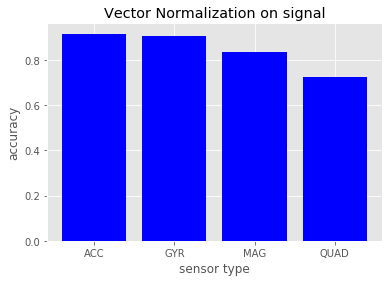

In [26]:
x = ['ACC', 'GYR', 'MAG', 'QUAD']
accuracy = [ACC_accuracy,GYR_accuracy,MAG_accuracy,QUAD_accuracy]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, accuracy, color='blue')
plt.xlabel("sensor type")
plt.ylabel("accuracy")
plt.title("Vector Normalization on signal")

plt.xticks(x_pos, x)

plt.show()